In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal as mvn
import scipy.stats as stats
import math

In [4]:
# Read the data into a pandas dataframe
salary_df = pd.read_csv('data/salaryData_bayesian/SalaryData.csv')
salary_df.head()

,YearsExperience,Salary
0,1.1,39343.0
1,1.3,46205.0
2,1.5,37731.0
3,2.0,43525.0
4,6.8,91738.0


In [5]:
salary_df.describe()

,YearsExperience,Salary
count,30.000000,30.000000
mean,5.313333,76003.000000
std,2.837888,27414.429785
min,1.100000,37731.000000
25%,3.200000,56720.750000
50%,4.700000,65237.000000
75%,7.700000,100544.750000
max,10.500000,122391.000000


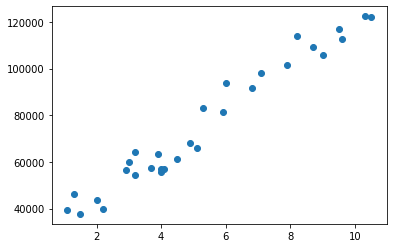

In [12]:
# Get a plot of the salary (y_axis) vs the years i.e. time (x_axis)
plt.scatter(salary_df['YearsExperience'], salary_df['Salary'])

In [11]:
# Initialize the params for the prior i.e. prior_mean, prior co-variance. Given as the part of the assignment
prior_cov = 100*np.identity(4)
prior_mean = np.array([40000,0,0,0])
print("prior mean:")
print(prior_mean)
print("prior covariance:")
print(prior_cov)

prior mean:
[40000     0     0     0]
prior covariance:
[[100.   0.   0.   0.]
 [  0. 100.   0.   0.]
 [  0.   0. 100.   0.]
 [  0.   0.   0. 100.]]


In [13]:
# We already know that the data is representative of a third order polynomial w.r.t to the yearsExprience i.e (time)
# Salary = Theta*T (vector multiplication) where T = [1, t, t^2, t^3] 
# Engineer the required features from given data: yearsExperience (we call our years as t)
salary_df['ye_sq']=salary_df['YearsExperience'].apply(lambda x: x*x)
salary_df['ye_cu']=salary_df['YearsExperience'].apply(lambda x: x*x*x)
salary_df['const'] = salary_df['YearsExperience'].apply(lambda x: x/x)

# Separate the labels (y-data i.e. Salaries) by creating y
y = salary_df['Salary']

# Drop the labels from the original dataframe and rename the columns
salary_df = salary_df.drop(columns = ['Salary'])
salary_df = salary_df[['const', 'YearsExperience','ye_sq', 'ye_cu']]

In [15]:
salary_df['const'] = salary_df['YearsExperience'].apply(lambda x: x/x)
salary_df = salary_df[['const', 'YearsExperience','ye_sq', 'ye_cu']]

# check if the engineered features are proper,
salary_df.head()

,const,YearsExperience,ye_sq,ye_cu
0,1.0,1.1,1.21,1.331
1,1.0,1.3,1.69,2.197
2,1.0,1.5,2.25,3.375
3,1.0,2.0,4.00,8.000
4,1.0,6.8,46.24,314.432


In [16]:
# Function for updating the co-variance values using the Woodbury Identity
def woodbury(p, h, variance):
    b_inv= np.power((h@p@h.transpose() + variance), -1)
    return p - p@h.transpose()@b_inv@h@p    

In [17]:
# Function to update the mean estimates
def mean(post_cov, prior_cov, h, y, prior_mean, variance):
    sig_inv = np.matrix(variance).getI()
    prior_cov_inv = prior_cov.getI()
    coeff = (h.transpose()@sig_inv@y) + prior_cov_inv @ prior_mean.transpose()
    return post_cov@coeff

In [18]:
# The observed variation is given as 250*250
variance = 250*250

# Function to update the model based on given one data vector at a time
def bayesian_update(n, salary_df, y):
    # initializing priors
    prior_cov = np.matrix(100 * np.identity(4))
    prior_mean = np.matrix(np.array([40000,0,0,0]))
    # loop to calculate the post_cov and post_mean
    for i in range(n):
        h = np.matrix(salary_df.values[i])
        y_k = np.matrix(y.values[i])
        post_cov = woodbury(prior_cov, h, variance)
        post_mean = mean(post_cov, prior_cov, h, y_k, prior_mean, variance)
    # update the terms for next iteration
        prior_cov = post_cov
        prior_mean = post_mean.transpose()
    
    return post_cov, post_mean.transpose()

In [21]:
# Perform Bayesian update for 10 data points ('p' is the co-variance and 'u' is the mean)
p10, u10 = bayesian_update(10, salary_df, y)

In [22]:
# Check the mean and co-variance for 10 updates...
print("posterior mean (10 data pts):")
print(u10)
print("posterior covariance (10 data pts):")
print(p10)

posterior mean (10 data pts):
[[4.00580979e+04 1.98796186e+02 5.67332265e+02 3.41185030e+01]]
posterior covariance (10 data pts):
[[ 98.99731623  -1.95964335  -3.57467222   0.2673962 ]
 [ -1.95964335  95.3294411  -10.38902585  -0.1321786 ]
 [ -3.57467222 -10.38902585  72.06425626  -8.32226437]
 [  0.2673962   -0.1321786   -8.32226437   1.07892547]]


In [23]:
# Perform Bayesian update for 30 data points i.e. full dataset ('p_full' is the co-variance and 'u_full' is the mean)
p_full, u_full = bayesian_update(len(salary_df), salary_df, y)
print("posterior mean (10 data pts):")
print(u_full)
print("posterior covariance (10 data pts):")
print(p_full)

posterior mean (10 data pts):
[[40072.17057539   355.67982027  1324.71598938   -53.82422696]]
posterior covariance (10 data pts):
[[ 98.74096776  -2.7336052   -5.02986195   0.43689653]
 [ -2.7336052   91.88701872 -21.13117985   1.17950301]
 [ -5.02986195 -21.13117985  26.78638907  -2.63424452]
 [  0.43689653   1.17950301  -2.63424452   0.28046664]]


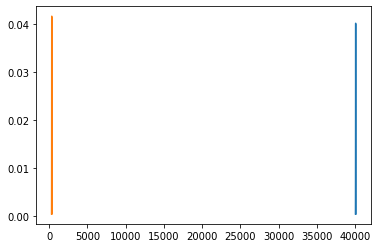

In [25]:
mu = u_full.getA()[0][0]
mu1 = u_full.getA()[0][1]
variance = p_full.getA()[0][0]
variance1 = p_full.getA()[1][1]

sigma = math.sqrt(variance)
sigma1 = math.sqrt(variance1)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x1 = np.linspace(mu1 - 3*sigma1, mu1 + 3*sigma1, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x1, stats.norm.pdf(x1, mu1, sigma1))
plt.show()

In [26]:
# Used to sample from the obtained gaussian (multivariate)
draw = np.random.multivariate_normal(u_full.getA()[0], p_full.getA(), 10)
theta_hat = draw[5]
# Randomly sample for theta_hat which will be used as the bayesian estimate of our parameters.
theta_hat

array([40083.74550794,   351.0962984 ,  1326.90653222,   -54.11090256])

In [27]:
# The predicted y-values (Salaries) based on theta_hat
y_predicted = np.zeros(len(salary_df))
# Dot product: Y = X*Theta_hat
for i in range(len(salary_df)):
    y_predicted[i] = np.dot(theta_hat,salary_df.values[i])

In [28]:
salary_df['y_predicted'] = y_predicted
salary_df.head()

,const,YearsExperience,ye_sq,ye_cu,y_predicted
0,1.0,1.1,1.21,1.331,42003.486729
1,1.0,1.3,1.69,2.197,42663.761082
2,1.0,1.5,2.25,3.375,43413.305357
3,1.0,2.0,4.00,8.000,45660.677013
4,1.0,6.8,46.24,314.432,86813.159074


In [30]:
# sorting the y values for a better looking plot
df = salary_df.sort_values('YearsExperience')
df.head()

,const,YearsExperience,ye_sq,ye_cu,y_predicted
0,1.0,1.1,1.21,1.331,42003.486729
1,1.0,1.3,1.69,2.197,42663.761082
2,1.0,1.5,2.25,3.375,43413.305357
3,1.0,2.0,4.00,8.000,45660.677013
5,1.0,2.2,4.84,10.648,46702.212090


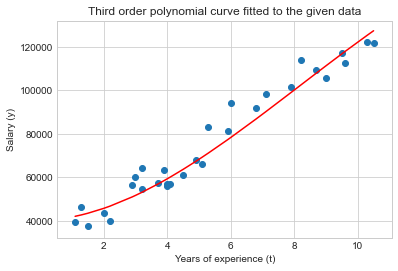

In [32]:
# Visualize the required plot
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()

# x = np.linspace(0, 10, 1000)
ax.set(xlabel='Years of experience (t)', ylabel='Salary (y)',
       title='Third order polynomial curve fitted to the given data')
# Plot the data points
ax.plot(df['YearsExperience'], df['y_predicted'], 'r')
# Plot our curve i.e. the third order polynomial based on sampled parameter(theta) values
ax.scatter(salary_df['YearsExperience'], y)